# Feature selection algorithms
This notebook evaluates all the features in the features sets and scores it according several algorithms. The scores can be used to train models only on features to meet certain criteria. Scores calculated:
- Sum of non-zero values
- Feature importance according ExtraTreesClassifier
- Pearson correlation coefficient
- Chi2
- Annova
- 

In [57]:
import pickle
import os

import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss
from sklearn.feature_selection import VarianceThreshold
from sklearn.grid_search import GridSearchCV

In [58]:
feat_dir = 'data'
data_dir = 'data_ori'

In [204]:
def open_feature_file(fname, samples='train'):
    if fname[-3:] == 'csv':
        if samples=='train':
            X = gatrain[['device_id']].merge( pd.read_csv(os.path.join(feat_dir, fname)), on='device_id', how='left')
        else:
            X = gatest[['device_id']].merge( pd.read_csv(os.path.join(feat_dir, fname)), on='device_id', how='left')
            
        X.drop('device_id', axis=1, inplace=True)
        X.fillna(0, inplace=True)
        
        for c in X.columns:
            if X[c].max()>1:
                #X[c] = StandardScaler().fit_transform(X)
                X[c] = MinMaxScaler().fit_transform(X)
                
        c = X.columns
    else:
        # Assume it is a pickle file
        with open(os.path.join(feat_dir, '{}_{}.pickle'.format(fname,samples)), 'rb') as f:
            X = pickle.load(f)
            c = np.arange(X.shape[1])
    
    return X, [fname + '_' + str(x) for x in c]


In [205]:
feature_files = ['features_events_totals.csv',
                 'features_appid_totals.csv',
                 'features_label_app_count.csv',
                 'features_group_app_count.csv',
                 'features_geo.csv',
                 'features_events_per_day.csv',
                 'features_events_per_hour_grouped.csv',
                 'features_events_per_hour.csv',
                 'features_events_per_quarter.csv',
                 'features_events_per_quarter_grouped.csv',
                 'features_brand_model_bag',
                 'features_brand_bag',
                 'features_brand_model.csv',
                 'features_appid_installed',
                 'features_appid_active',
                 'features_appid_r_active',
                 'features_appid_installed_active',
                 'features_appid_installed_rel',
                 'features_appid_active_rel',
                 'features_label_app_installed',
                 'features_label_app_installed_prop',
                 'features_label_app_active_rel',
                 'features_label_app_more_active_week',
                 'features_label_app_more_active_day',
                 'features_group_app_installed_count.csv',
                 'features_group_app_installed_prop.csv',
                 'features_group_app_active_count.csv',
                 'features_group_app_active_prop.csv',
                 'features_group_app_active_rel.csv']


In [206]:
gatrain = pd.read_csv(os.path.join(data_dir,'gender_age_train.csv'))
gatest = pd.read_csv(os.path.join(data_dir,'gender_age_test.csv'))

targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [211]:
res = [open_feature_file(f) for f in feature_files]
X = hstack([data[0] for data in res], format='csr')

# Get feature names and flatten list
fea_names = [item for sublist in [data[1] for data in res] for item in sublist]
print X.shape
print len(fea_names)

(74645, 119856)
['features_events_totals.csv_n_events', 'features_events_totals.csv_r_hour_with_events', 'features_events_totals.csv_r_day_with_events', 'features_events_totals.csv_r_hour_grouped_with_events', 'features_events_totals.csv_r_event_weekend', 'features_events_totals.csv_r_event_day', 'features_appid_totals.csv_n_u_apps_installed', 'features_appid_totals.csv_n_u_apps_active', 'features_appid_totals.csv_r_u_apps_active', 'features_label_app_count.csv_n_u_labels_installed_apps']


In [63]:
# Store various feature selection results in a single dataframe
df_feat = pd.DataFrame({'name':fea_names})

### Values great than zero

In [66]:
(X>0).sum(axis=0).shape

(1, 119856)

In [74]:
df_feat['sum_gr_0'] = (X>0).sum(axis=0).T

### Tree-based feature selection

In [75]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

In [76]:
clf = ExtraTreesClassifier()
clf = clf.fit(X,y)

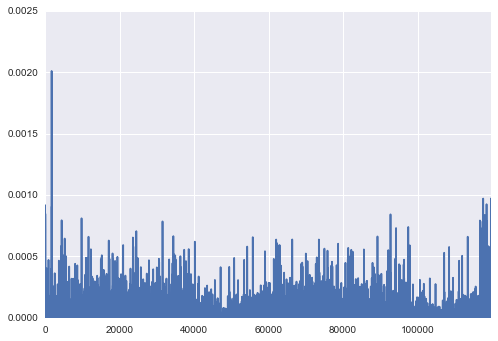

In [25]:
pd.Series(clf.feature_importances_).plot()

In [77]:
df_feat['extra_trees'] = clf.feature_importances_

In [23]:
df_feat.head()

,extra_trees
0,0.000681
1,0.000844
2,0.000701
3,0.000753
4,0.000886


### SelectPercentile

In [70]:
from sklearn.feature_selection import SelectPercentile, f_classif, chi2


In [71]:
scorers = {'annova':f_classif, 'chi2': chi2}

for name,scorer in scorers.iteritems():
    sel = SelectPercentile(scorer).fit(X,y)
    df_feat[name + '_score'] = sel.scores_
    df_feat[name + '_p'] = sel.pvalues_

In [72]:
df_feat.sample(10)

,chi2_score,chi2_p,annova_score,annova_p
31899,12.708907,3.127761e-01,1.155382,3.127778e-01
71541,3.385737,9.845841e-01,0.615554,8.172987e-01
38220,19.801993,4.813125e-02,1.802132,4.784211e-02
42635,NaN,NaN,NaN,NaN
96669,9.769214,5.512583e-01,1.034999,4.116109e-01
102250,NaN,NaN,NaN,NaN
12271,114.266430,2.567162e-19,10.460074,1.847656e-19
59144,NaN,NaN,NaN,NaN
57786,NaN,NaN,NaN,NaN
107773,6.050798,8.699534e-01,1.580911,9.688280e-02


### Correlation coefficients

In [78]:
from scipy.stats import pearsonr

In [89]:
X[:,1]

<74645x1 sparse matrix of type '<type 'numpy.float64'>'
	with 23309 stored elements in Compressed Sparse Row format>

In [105]:
for i,c in enumerate(X.T):
    df_feat.loc[i,'pearson_score'] = pearsonr(c.todense().getA1(),y)[0]
    RandomizedLogisticRegression.loc[i,'pearson_p'] = pearsonr(c.todense().getA1(),y)[1]

### Randomized Logistic Regression

In [106]:
from sklearn.linear_model import RandomizedLogisticRegression

In [111]:
clf = RandomizedLogisticRegression(C=0.02)
clf.fit(X,y)

RandomizedLogisticRegression(C=0.02, fit_intercept=True,
               memory=Memory(cachedir=None), n_jobs=1, n_resampling=200,
               normalize=True, pre_dispatch='3*n_jobs', random_state=None,
               sample_fraction=0.75, scaling=0.5, selection_threshold=0.25,
               tol=0.001, verbose=False)

In [131]:
df_feat['random_log_score'] = pd.Series(clf.scores_)

### Visualize results

In [179]:
score_cols = ['chi2_score', 'annova_score', 'extra_trees', 'pearson_score', 'random_log_score']

In [157]:
df_feat.sample(10)

,chi2_score,chi2_p,annova_score,annova_p,sum_gr_0,extra_trees,pearson_score,pearson_p,random_log_score
10660,9.212751,0.602262,0.837503,0.602283,1,0.0,0.002804,0.443557,0.0
43956,NaN,NaN,NaN,NaN,0,0.0,NaN,1.000000,0.0
93866,10.246017,0.508403,0.999638,0.443610,3,0.0,-0.001092,0.765471,0.0
17758,NaN,NaN,NaN,NaN,0,0.0,NaN,1.000000,0.0
119294,10.527518,0.483651,0.957670,0.483064,50,0.0,0.005766,0.115192,0.0
106533,NaN,NaN,NaN,NaN,0,0.0,NaN,1.000000,0.0
65290,5.938683,0.877424,1.079817,0.372902,4,0.0,0.001284,0.725669,0.0
44766,NaN,NaN,NaN,NaN,0,0.0,NaN,1.000000,0.0
71170,6.354454,0.848699,1.155382,0.312778,1,0.0,0.001723,0.637768,0.0
86020,NaN,NaN,NaN,NaN,0,0.0,NaN,1.000000,0.0


In [181]:
def plot_sel_crit(df):
    f, axes = plt.subplots(nrows=df.shape[1], ncols=1, figsize=(16,16))
    cmap = plt.cm.jet

    for i, v in enumerate(df):
        axes[i].scatter(x=df.index, y=df[v], s=5, linewidth=0.001, alpha=0.5, c=cmap(float(i)/df.shape[1]))
        axes[i].set_title(v)

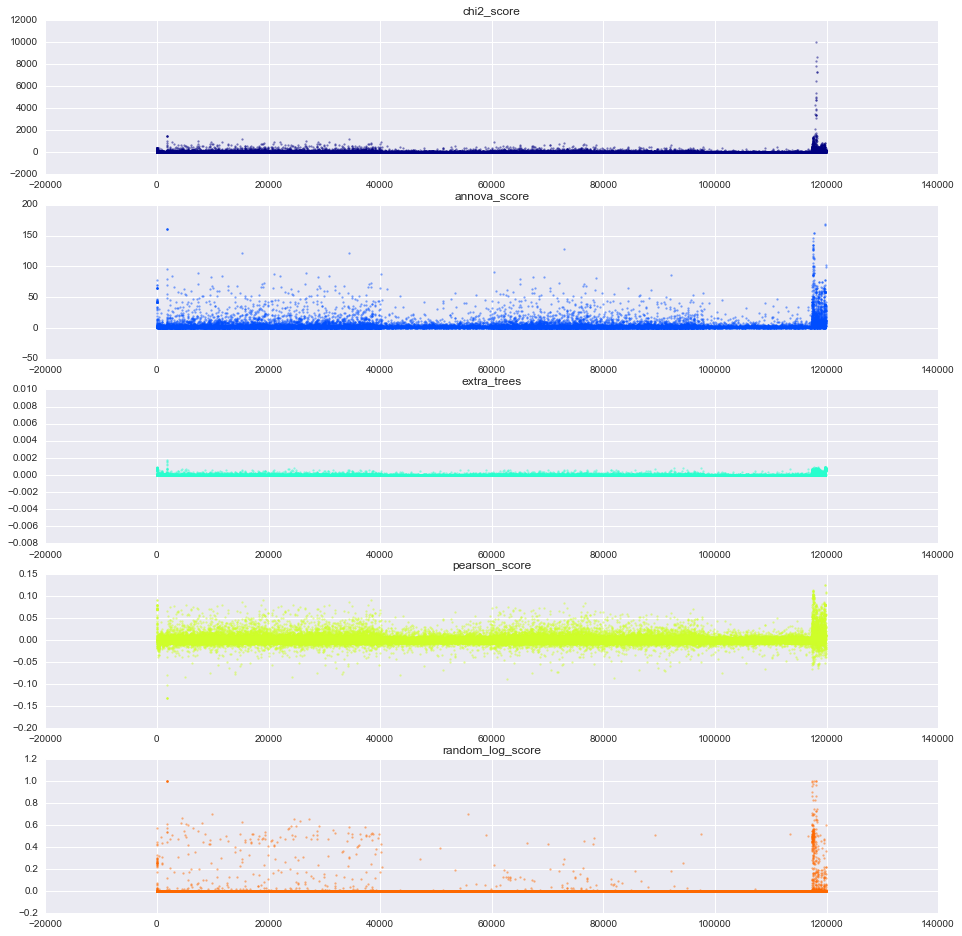

In [182]:
# Plot results without any filtering
plot_sel_crit(df_feat[score_cols])

In [1]:
(df_feat>100).sum()

NameError: name 'df_feat' is not defined

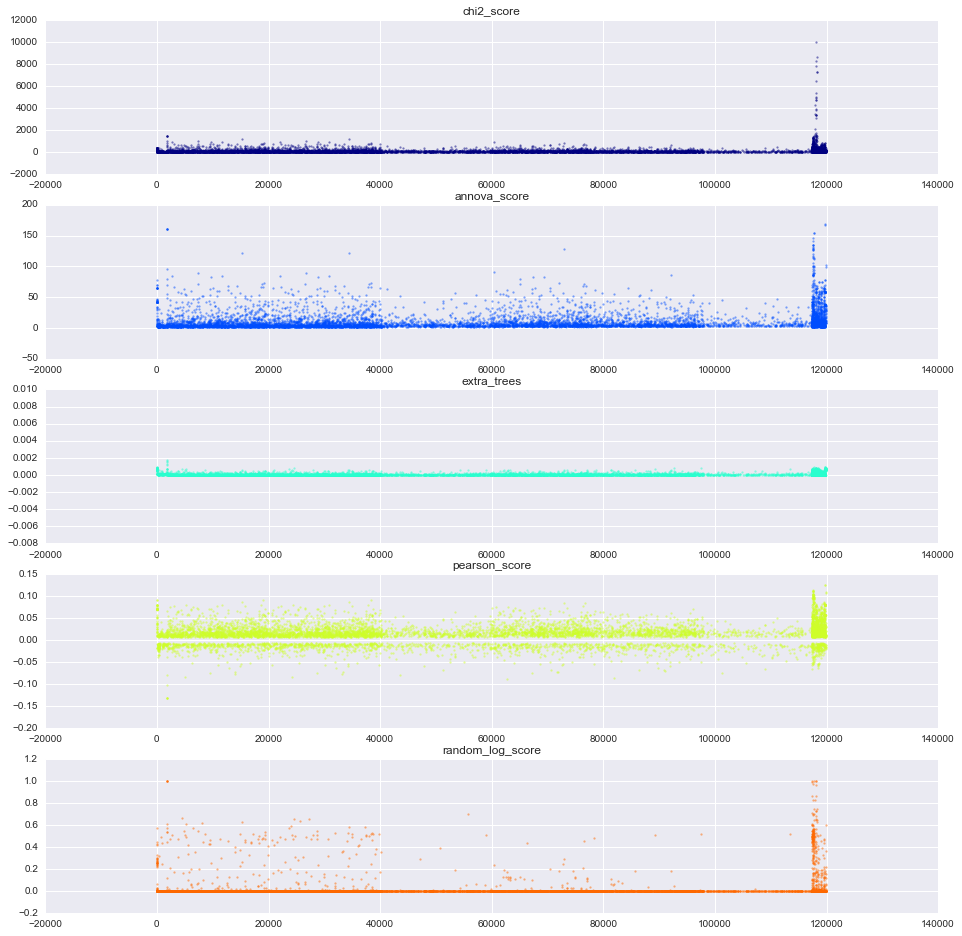

In [184]:
# Filter based on p-values:
p_min = 0.05
df_feat_p = df_feat[ (df_feat.chi2_p<p_min) & (df_feat.annova_p<p_min) & (df_feat.pearson_p<p_min)]
plot_sel_crit(df_feat_p[score_cols])

In [216]:
df_feat.fillna(0, inplace=True)
df_feat.to_csv(feat_dir + '/_selection_criteria.csv', index=True, index_label='feat_nr')

In [217]:
df_feat.sample(10)

,chi2_score,chi2_p,annova_score,annova_p,sum_gr_0,extra_trees,pearson_score,pearson_p,random_log_score,names
106974,0.000000,0.000000e+00,0.000000,0.000000e+00,0,0.000000,0.000000,1.000000e+00,0.0,features_appid_active_rel_8910
117423,171.690711,5.294207e-31,15.827247,1.850186e-31,873,0.000095,0.027404,6.976036e-14,0.0,features_label_app_installed_122
73598,8.598828,6.588678e-01,0.781707,6.588699e-01,3,0.000000,0.000488,8.939244e-01,0.0,features_appid_installed_active_14008
118154,31.538564,9.041418e-04,3.088517,3.660741e-04,3208,0.000356,0.017372,2.068611e-06,0.0,features_label_app_installed_prop_361
2746,0.000000,0.000000e+00,0.000000,0.000000e+00,0,0.000000,0.000000,1.000000e+00,0.0,features_appid_installed_867
33946,9.212751,6.022616e-01,0.837503,6.022831e-01,1,0.000000,0.002804,4.435568e-01,0.0,features_appid_active_12830
95501,9.414274,5.837104e-01,1.289446,2.230101e-01,37,0.000000,0.004616,2.072323e-01,0.0,features_appid_installed_rel_16674
89520,17.381832,9.707753e-02,1.983291,2.585179e-02,9,0.000000,-0.001589,6.641497e-01,0.0,features_appid_installed_rel_10693
51832,6.007345,8.728737e-01,0.871736,5.676855e-01,15,0.000000,0.006786,6.375469e-02,0.0,features_appid_r_active_11479
61860,3.849435,9.741161e-01,0.699866,7.400217e-01,1,0.000000,0.004967,1.747925e-01,0.0,features_appid_installed_active_2270
